In [22]:
import pandas as pd

from significance_analysis import conduct_analysis

# Load example dataset
data = pd.read_csv("./example_dataset.csv")

In [23]:
import numpy as np
import matplotlib.pyplot as plt
def algo_simulator(budget:int,workers_power:int,quality:float,noise:float):
    runs=[]
    for i in range((2**workers_power)):
        runs.append([1])
    prev_workers=2**workers_power
    for i in range(1,budget):
        multiplier=budget/(i+1)
        current_workers=2**min(np.floor(np.log2(multiplier)),workers_power)
        runs= sorted(runs, key=lambda x: x[-1])
        if current_workers!=prev_workers:
            for worker in range(int(current_workers)):
                new_point=(np.exp(-quality*i)+np.random.normal(size=1,scale=noise))[0]
                runs[worker].append(min([runs[worker][-1],new_point]))
        prev_workers=current_workers
    return runs

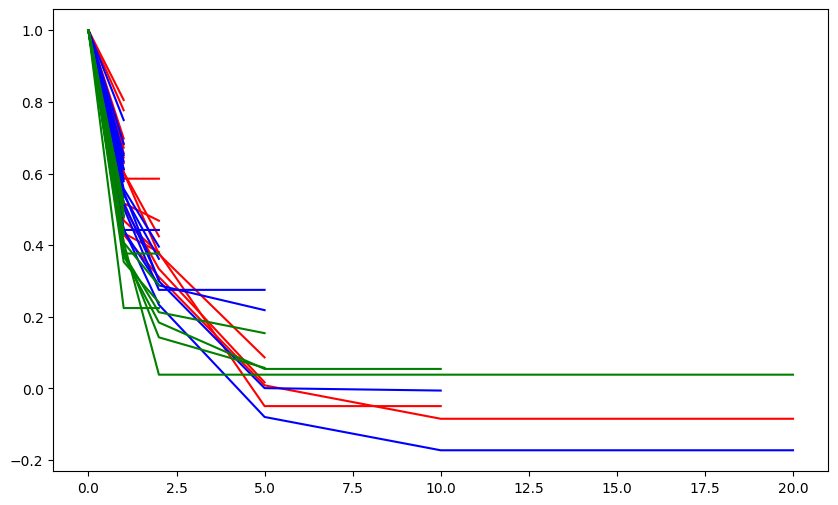

In [59]:
max_budget=40
number_of_workers_power=6
quality=[0.5,0.6,0.8]
colors=["red","blue","green"]
noise=0.1

runs=[]
y_data=[]
algo_numbers=[]
for algo_number in range(len(quality)):
    run=algo_simulator(budget=max_budget,workers_power=number_of_workers_power,quality=quality[algo_number],noise=noise)
    runs+=run
    algo_numbers+=list(np.ones(shape=len(run),dtype=int)*algo_number)

for run in runs:
    y_data.append([])
    for i in range(0,len(run)):
        y_data[-1].append(int((2**i/2**number_of_workers_power)*max_budget))



_, axis = plt.subplots(figsize=(10, 6))
for number,group in enumerate(runs):
    axis.errorbar(
        y_data[number],
        group,
        fmt="-",
        color=colors[algo_numbers[number]]
    )
plt.show()

In [60]:
saved_runs=runs
saved_y_data=y_data
saved_algo_numbers=algo_numbers


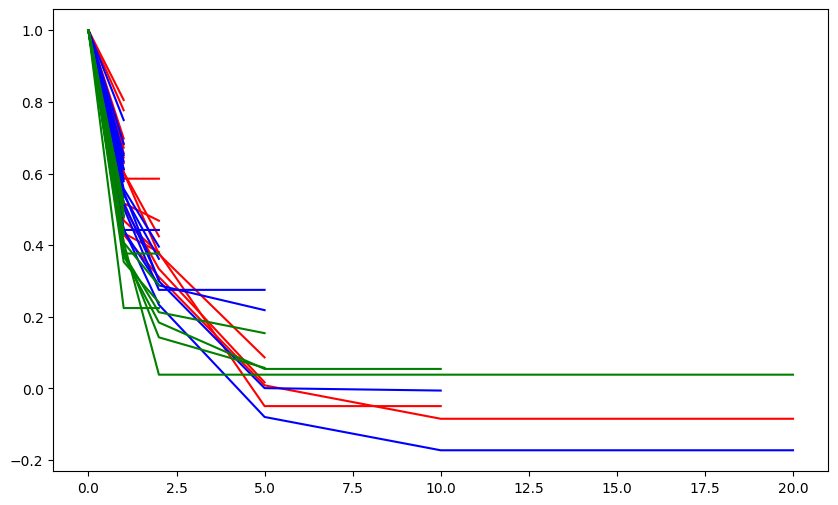

In [61]:
import warnings
import random
warnings.simplefilter(action='ignore', category=FutureWarning)


_, axis = plt.subplots(figsize=(10, 6))
for number,group in enumerate(saved_runs):
    axis.errorbar(
        saved_y_data[number],
        group,
        fmt="-",
        color=colors[algo_numbers[number]]
    )
plt.show()

df=pd.DataFrame(columns=["score","budget","algo","rng"])
for run_number,run in enumerate(saved_runs):
    for data_number,datapoint in enumerate(run):
        df.loc[len(df)] =[datapoint,saved_y_data[run_number][data_number],str(saved_algo_numbers[run_number]),str(random.randint(0,2))]


#conduct_analysis(df,"score","algo","rng")

In [62]:
from pymer4 import Lmer


metric="score"
system_id="algo"
input_id="rng"
random_effect="budget"
df["budget"]=df["budget"].astype(int)
df["rng"]=df["rng"].astype(str)
df["algo"]=df["algo"].astype(str)
df["score"]=df["score"].astype(float)

subsets=[[0,1,2],[5,10,20]]

for subset in subsets:
    print(f"Subsetted data: {subset}")
    #print(df.loc[df["budget"].isin(subset)])
    subsetted_data = Lmer(
        formula=f"{metric}~{system_id}+(1|{input_id})+(1|{random_effect})", data=df.loc[df["budget"].isin(subset)]
    )
    # factors specifies names of system_identifier, i.e. Baseline, or Algorithm1
    subsetted_data.fit(
        factors={system_id: list(df[system_id].unique())},
        REML=False,
        summarize=False,
    )
    #print(subsetted_data.summary())
    #print("Ranef:")
    #print(subsetted_data.ranef)
    print()
    post_hoc_results2 = subsetted_data.post_hoc(marginal_vars=[system_id])
    print(post_hoc_results2)


mapping = {x: index for index, sublist in enumerate(subsets) for x in sublist}
df[f"budget_coded"] = df["budget"].apply(lambda x: mapping[x])
bin_labels = list(df["budget_coded"].unique())
df[f"budget_bins"] = pd.cut(
    df[f"budget_coded"],
    bins=len(subsets),
    labels=bin_labels,
    include_lowest=True,
).astype(str)

fixed_effect_model = Lmer(
    formula=f"{metric}~{system_id}+ budget_bins + {system_id}:budget_bins + (1|{random_effect})+(1|{input_id})", data=df
)

# factors specifies names of system_identifier, i.e. Baseline, or Algorithm1
fixed_effect_model.fit(
    factors={system_id: list(df[system_id].unique())},
    REML=False,
    summarize=False,
)
print(fixed_effect_model.summary())
print("Ranef:")
print(fixed_effect_model.ranef)
print()





post_hoc_results3 = fixed_effect_model.post_hoc(marginal_vars=[system_id])
print(post_hoc_results3)

Subsetted data: [0, 1, 2]
boundary (singular) fit: see help('isSingular') 


P-values adjusted by tukey method for family of 3 estimates
(  algo  Estimate  2.5_ci  97.5_ci     SE     DF
1    0     0.638   0.113    1.163  0.165  3.006
2    1     0.624   0.099    1.148  0.165  3.006
3    2     0.587   0.062    1.111  0.165  3.006,         Contrast  Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val  Sig
1  algo0 - algo1     0.014  -0.006    0.035  0.009  261.001   1.639  0.231     
2  algo0 - algo2     0.051   0.031    0.072  0.009  261.001   5.859  0.000  ***
3  algo1 - algo2     0.037   0.016    0.058  0.009  261.001   4.220  0.000  ***)
Subsetted data: [5, 10, 20]

P-values adjusted by tukey method for family of 3 estimates
(  algo  Estimate  2.5_ci  97.5_ci     SE     DF
1    0    -0.041  -0.148    0.067  0.046  7.273
2    1    -0.007  -0.119    0.105  0.046  6.260
3    2     0.044  -0.063    0.151  0.046  7.273,         Contrast  Estimate  2.5_ci  97.5_ci     SE      DF  T-sta

In [28]:
def algo_simulator2(budget:int,workers_power:int,quality:float,noise:float):
    runs=[]
    for i in range((2**workers_power)):
        runs.append([1])
    prev_workers=2**workers_power
    for i in range(1,budget):
        multiplier=budget/(i+1)
        current_workers=2**min(np.floor(np.log2(multiplier)),workers_power)
        runs= sorted(runs, key=lambda x: x[-1])
        if current_workers!=prev_workers:
            for worker in range(int(current_workers)):
                new_point=(np.exp(-quality*i)+np.random.normal(size=1,scale=noise))[0]
                runs[worker].append(min([runs[worker][-1],new_point]))
        prev_workers=current_workers
    return runs

max_budget=20
number_of_workers_power=4
quality=[0.5,0.6,0.8]
colors=["red","blue","green"]
noise=0.1
pd.set_option("chained_assignment", None)
pd.set_option("display.max_rows", 5000)
pd.set_option("display.max_columns", 5000)
pd.set_option("display.width", 10000)

runs=[]
y_data=[]
algo_numbers=[]
for algo_number in range(len(quality)):
    run=algo_simulator2(budget=max_budget,workers_power=number_of_workers_power,quality=quality[algo_number],noise=noise)
    runs+=run
    algo_numbers+=list(np.ones(shape=len(run),dtype=int)*algo_number)

for run in runs:
    y_data.append([])
    for i in range(0,len(run)):
        y_data[-1].append(int((2**i/2**number_of_workers_power)*max_budget))




saved_runs=runs
saved_y_data=y_data
saved_algo_numbers=algo_numbers

df=pd.DataFrame(columns=["score","budget","algo","rng"])
for run_number,run in enumerate(saved_runs):
    for data_number,datapoint in enumerate(run):
        df.loc[len(df)] =[datapoint,saved_y_data[run_number][data_number],str(saved_algo_numbers[run_number]),str(random.randint(0,2))]
repeated_df=pd.DataFrame(columns=["score","budget","algo","rng"])
for budget in df["budget"].unique():
    #print(budget)
    df_budget=df.loc[df["budget"]==budget]
    #print(number_of_workers_power-min(np.floor(np.log2(max_budget/(budget))),number_of_workers_power)+1)
    #print(np.repeat(df_budget.values,number_of_workers_power-min(np.floor(np.log2(max_budget/(budget))),number_of_workers_power)+1,axis=0))
    repeated_df=pd.concat([repeated_df,pd.DataFrame(np.repeat(df_budget.values,2**(number_of_workers_power-min(np.floor(np.log2(max_budget/(budget))),number_of_workers_power)+1)-1,axis=0),columns=["score","budget","algo","rng"])],ignore_index=True)
#print(repeated_df)
repeated_df["score"]=repeated_df["score"].apply(float)

fixed_effect_model = Lmer(
    formula=f"{metric}~{system_id}+(1|{random_effect})+(1|{input_id})", data=repeated_df
)

# factors specifies names of system_identifier, i.e. Baseline, or Algorithm1
fixed_effect_model.fit(
    factors={system_id: list(df[system_id].unique())},
    REML=False,
    summarize=False,
)
print(fixed_effect_model.summary())
print("Ranef:")
print(fixed_effect_model.ranef)
print()


post_hoc_results3 = fixed_effect_model.post_hoc(marginal_vars=[system_id])
print(post_hoc_results3)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: score~algo+(1|budget)+(1|rng)

Family: gaussian	 Inference: parametric

Number of observations: 387	 Groups: {'budget': 5.0, 'rng': 3.0}

Log-likelihood: 361.828 	 AIC: -711.656

Random effects:

                 Name    Var    Std
budget    (Intercept)  0.143  0.378
rng       (Intercept)  0.001  0.037
Residual               0.008  0.090

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val  Sig
(Intercept)     0.396   0.062    0.730  0.170    5.167   2.321  0.066    .
algo1          -0.016  -0.038    0.007  0.012  381.877  -1.344  0.180     
algo2          -0.086  -0.108   -0.064  0.011  380.291  -7.644  0.000  ***
Ranef:
[    X.Intercept.
1       0.632376
2       0.165229
5      -0.080667
10     -0.259378
20     -0.457558,    X.Intercept.
0      0.041323
1     -0.021113
2     -0.020210]

P-values adjusted by tukey method for family of 3 estimate